Import the libraries needed

In [1]:
%matplotlib inline
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt
import yaml

Change the data `.yaml` file link to the one you use

In [2]:
# Open the YAML file
with open('data/data_trail_240528.yaml', 'r') as file:
    # Load the contents of the file
    content = yaml.safe_load(file)

# Extract the 'names' list
names_list = content.get('names', [])

# Print the list
print(names_list)

['ball', 'bat', 'gloves', 'helmet', 'pads', 'stumps']


Load the data for the segment inference result

*change the Link for the mask result*

In [3]:
# Path to the saved text file containing the segmentation mask
mask_file_path = "runs/predict-seg/exp37/labels/test_hr.txt"

# Read the lines from the file
with open(mask_file_path, "r") as f:
    mask_lines = f.readlines()

def parse_mask_line(line):
    # Split the string by spaces
    data_points = line.strip().split()

    # Convert each element to float using a loop
    float_data = [float(point) for point in data_points]

    # Reshape the points into an array of x,y pairs
    return float_data

Plot the segment result in images

*Change the path of the original image*

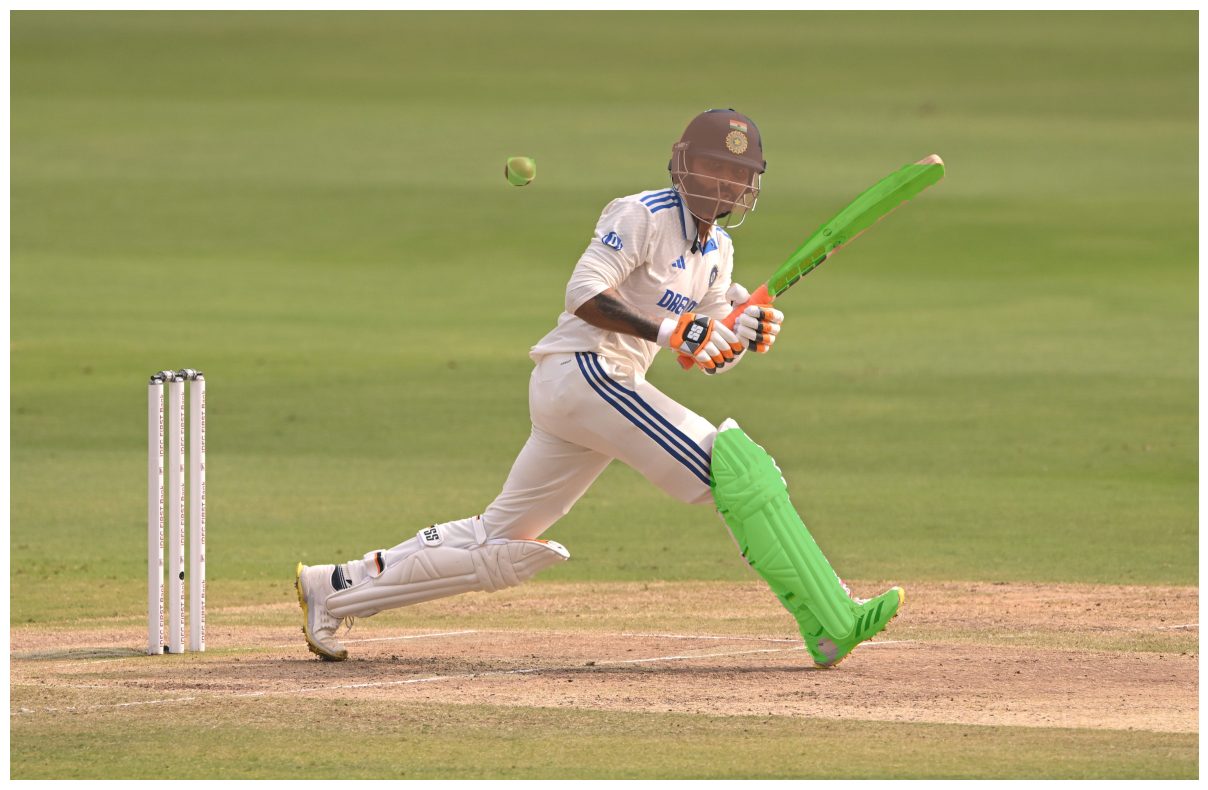

In [6]:
# Parse mask data
category = [parse_mask_line(line)[0] for line in mask_lines]
points = [parse_mask_line(line)[1:] for line in mask_lines]

# Extract x and y coordinates
x_coords = [point[::2] for point in points]
y_coords = [point[1::2] for point in points]

colors={}

# Generate random colors for each category
for n in category:
    colors[names_list[int(n)]] = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

# Load the image
image = cv2.imread("../custom_dataset/test/images/test_hr.jpg")
height, width, channels = image.shape

# Create an overlay image
overlay = image.copy()


# Loop through each mask (polygon) and draw it on the overlay image
for mask, n in zip(points, category):
    if mask != []:
        mask = np.array(mask).reshape((-1, 2))
        mask = mask*[width,height]
        mask= np.int32([mask])
        color = colors[names_list[int(n)]]
        cv2.fillPoly(overlay, mask, color)

# Blend the overlay with the original image
alpha = 0.5
cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, image)

# Display the image with the drawn masks inline
plt.figure(figsize=(20, 10))  # Set figure size to display the full-size image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis numbers
plt.show()


Caculate the area of the categories

In [10]:
#calculate area for each catrgories

def shoelace_area(points):
    area_temp = 0
    for i in range(len(points) - 1):
        x1, y1 = points[i]
        x2, y2 = points[i + 1]
        area_temp += (x1 * y2 - x2 * y1)
    return abs(area_temp / 2.0)  # Absolute value for total enclosed area

area={name:0 for name in names_list}

for mask, n in zip(points, category):
    mask = np.array(mask).reshape((-1, 2))
    mask = mask*[width, height]
    mask=  np.int32(mask)
    area[names_list[int(n)]] += shoelace_area(mask)

print(area)

{'ball': 29225.0, 'bat': 378878.5, 'gloves': 0, 'helmet': 139895.0, 'pads': 0, 'stumps': 0}


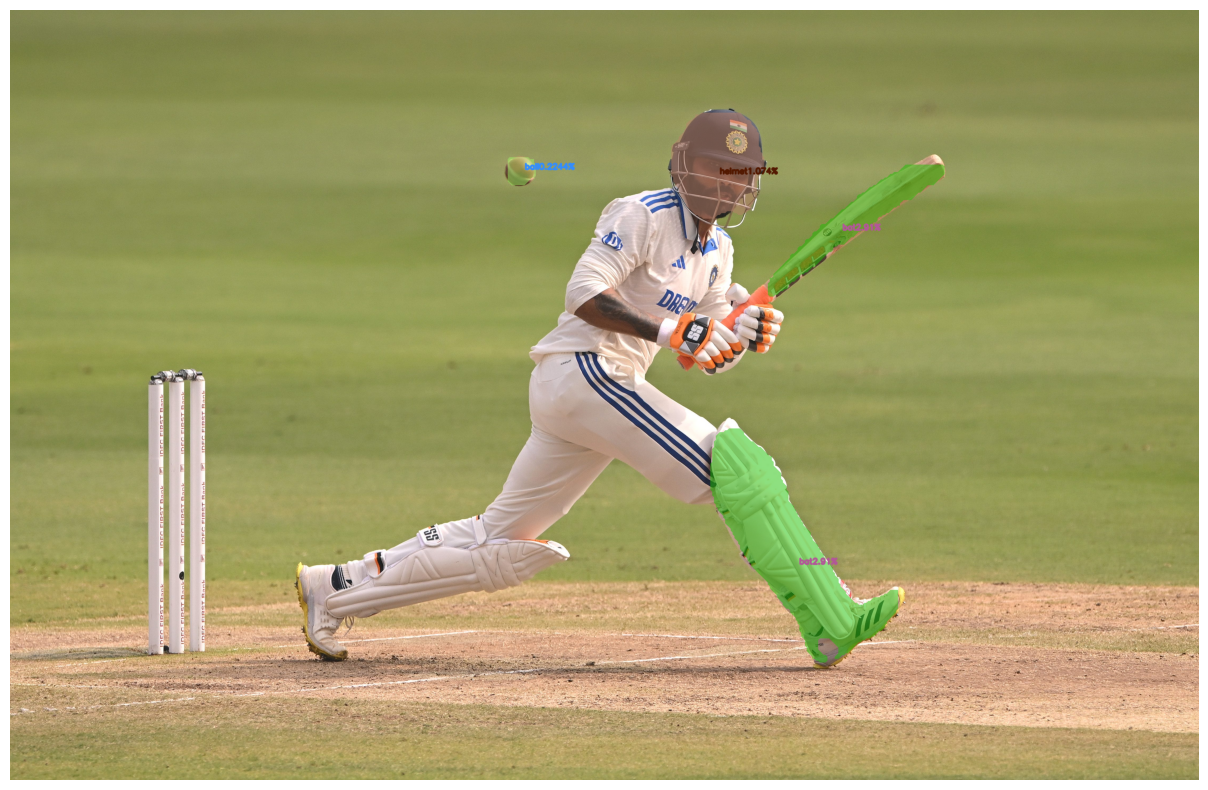

In [11]:
area_precentage={}
for i in area:
    area_precentage[i]=area[i]/width/height*100

for mask, n in zip(points, category):
    mask = np.array(mask).reshape((-1, 2))
    mask = mask*[width, height]
    mask=  np.int32(mask)
    # Calculate the midpoint of the mask
    mask_midpoint = np.mean(mask, axis=0, dtype=np.int32).flatten()

    #Set the color for the label
    color = tuple([int((x+150)%255) for x in colors[names_list[int(n)]]])
    #Set up the label content
    content = names_list[int(n)] + str('{:.4}'.format(area_precentage[names_list[int(n)]])) + '%'

    # Add label to the midpoint
    cv2.putText(image, content, tuple(mask_midpoint), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 5, cv2.LINE_AA)

# Display the image with the drawn masks inline
plt.figure(figsize=(20, 10))  # Set figure size to display the full-size image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis numbers
plt.show()
